In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

I used anaconda version: 25.1.0 for this project, but i dont think it will cause issues

# easy functions(did not code myself, the rest is all mine)

In [2]:
#definitions to make coding easier

def number_of_movies(ratings):
    """ determine the number of unique movie id's in the data """
    return len(ratings['movieId'].unique())

def number_of_users(ratings):
    """ determine the number of unique user id's in the data """
    return len(ratings['userId'].unique())

def number_of_ratings(ratings):
    """ count the number of ratings of a dataset """
    return ratings.shape[0]

def get_rating(ratings, userId, movieId):
    """Given a userId and movieId, this function returns the corresponding rating.
       Should return NaN if no rating exists."""
    
    corresponding_rating = ratings.loc[(ratings["userId"] == userId) & (ratings["movieId"] == movieId)]['rating']
    
    return corresponding_rating.iloc[0] if not corresponding_rating.empty else np.nan  

def rating_density(ratings):
    """ compute the ratings given a data set """
    return number_of_ratings(ratings) / (number_of_movies(ratings) * number_of_users(ratings))

def split_data(data,d = 0.75):
    """ split data in a training and test set 
       `d` is the fraction of data in the training set"""
    np.random.seed(seed=5)
    mask_test = np.random.rand(data.shape[0]) < d
    return data[mask_test], data[~mask_test]

In [4]:
# Load the subset with density of 80%
ratings_t80 = pd.read_csv('./ratings_t80.csv')

#split subset into test set and training set
ratings_t80_training, ratings_t80_test = split_data(ratings_t80)

# Show the stats
print('Stats training set:')
print(f'Number of ratings: {number_of_ratings(ratings_t80_training)}')
print(f'Number of users: {number_of_users(ratings_t80_training)}')
print(f'Number of movies: {number_of_movies(ratings_t80_training)}')
print(f'Density: {rating_density(ratings_t80_training)}')

# Display the first 5 rows of the data
display(ratings_t80.head())

Stats training set:
Number of ratings: 3006
Number of users: 25
Number of movies: 200
Density: 0.6012


,userId,movieId,rating,timestamp
0,68,1,2.5,1158531426
1,68,2,2.5,1158532776
2,68,16,3.5,1158533018
3,68,47,4.0,1158531489
4,68,50,3.0,1158531764


# Matrix Functions

In [5]:
#Takes a rating table as input and computes the utility matrix using pandas pivot function.
def pivot_ratings(ratings):
    
    return ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating') 

#Cleans up the dataset by giving not watched movies NAN
def fill_nan_mean(matrix):
    # get the mean for each row
    meanv = matrix.mean(axis = 1, skipna=True)
    
    # fill all nan values with mean 
    filled1 = matrix.T.fillna(meanv).T
    
    #if entire row is nan, fill with 0
    filled2 = filled1.fillna(0)
    return filled2

def mean_center_columns(matrix):
    for i in matrix:
        matrix[i] = matrix[i] - matrix[i].mean()
        
    return matrix
    
from sklearn.metrics.pairwise import cosine_similarity as cosine_similarity_sklearn

#Creates similarity matrix from the utility matrix. The function from sklearn
#does not take NaN values so we temporarily fill them with the mean rating
#from a movie.
def create_similarity_matrix_cosine(utility_matrix):

    # sklearn needs a numpy ndarray as input, so convert the matrix
    matrix = np.array(utility_matrix)
    
    similarities = cosine_similarity_sklearn(matrix)
    
    # convert the output back to a pandas dataframe
    similarity_matrix = pd.DataFrame(data=similarities[0:,0:],
                                    index=utility_matrix.index,
                                    columns=utility_matrix.index)

    return similarity_matrix

#selects the k items all items with similarity > 0
def select_neighborhood(similarities, ratings, k):
    
    drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
    similarities.drop(drop_nan, inplace=True)
    
    return similarities.sort_values().where(similarities > 0).dropna().head(k)

def weighted_mean(neighborhood, ratings):  
    if len(neighborhood) == 0:
        return np.nan
    return neighborhood.mul(ratings).sum() / neighborhood.sum()

In [6]:
utility = pivot_ratings(ratings_t80_training)

centered_utility = fill_nan_mean(utility)
centered_utility = mean_center_columns(centered_utility)

similarity = create_similarity_matrix_cosine(centered_utility)

display(utility.head())
display(similarity.head())

userId,68,105,177,182,232,249,274,288,298,307,...,474,480,483,590,599,600,603,606,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,2.5,NaN,NaN,4.0,NaN,4.0,4.0,4.5,2.0,4.0,...,4.0,NaN,NaN,4.0,3.0,2.5,4.0,2.5,NaN,NaN
2,NaN,NaN,3.5,NaN,4.0,4.0,3.5,2.0,0.5,2.5,...,3.0,3.0,4.0,2.5,NaN,4.0,NaN,NaN,2.0,NaN
16,3.5,4.5,NaN,5.0,NaN,NaN,4.5,NaN,NaN,NaN,...,4.0,4.0,4.0,NaN,3.0,NaN,4.0,NaN,4.5,4.5
32,NaN,3.5,NaN,4.0,NaN,5.0,4.0,NaN,4.0,3.5,...,4.0,4.0,5.0,3.0,3.0,NaN,3.0,4.0,NaN,4.5
47,NaN,5.0,4.5,NaN,4.5,5.0,4.0,NaN,4.0,4.0,...,NaN,4.5,3.5,3.0,4.0,4.0,NaN,3.0,4.5,5.0


movieId,1,2,16,32,47,50,104,110,153,223,...,46578,48385,48394,48516,48780,51662,52722,53125,58559,59315
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.168743,-0.020040,-0.096972,-0.022351,0.151485,-0.230859,0.121628,-0.022195,0.176785,...,-0.032943,0.282065,-0.139659,0.099080,0.217189,-0.099192,0.075603,-0.160189,-0.103409,0.044789
2,0.168743,1.000000,-0.482041,-0.204514,-0.463949,-0.436061,0.372800,0.186018,0.613228,-0.023415,...,-0.126030,0.096443,-0.154763,-0.407525,0.106556,-0.039754,0.462021,0.510987,-0.521303,-0.317854
16,-0.020040,-0.482041,1.000000,0.113875,0.489484,0.644972,-0.309973,-0.099919,-0.418123,-0.068501,...,0.313134,0.286079,0.062617,0.555116,0.158434,0.245228,-0.407579,-0.170303,0.492128,0.330839
32,-0.096972,-0.204514,0.113875,1.000000,0.442989,0.328448,-0.506858,0.119328,-0.497107,-0.034309,...,0.343029,-0.072641,0.510843,0.297535,0.422813,0.165825,-0.581471,-0.387422,0.506793,0.570990
47,-0.022351,-0.463949,0.489484,0.442989,1.000000,0.349315,-0.595072,-0.168127,-0.666247,-0.332830,...,0.094299,-0.006233,0.153809,0.700517,0.393713,0.249888,-0.547349,-0.159551,0.628873,0.488278


In [8]:
#Create Pickel files to speed up similarity matrixes and calculations.
ratings = pd.read_csv(f'./ratings_t80.csv')[['userId', 'movieId', 'rating', 'timestamp']]

training_data = pd.read_pickle(f'./ratings_t80_training.pkl')
test_data = pd.read_pickle(f'./ratings_t80_test.pkl')
utility_items = pd.read_pickle(f'./ratings_t80_utility_items.pkl')
similarity_items = pd.read_pickle(f'./ratings_t80_similarity_items.pkl')

# Item Based Collaborative Filtering

In [10]:
#Function that predicts rating in the test data. This algorithm is item based. The input consists 
# of the similarity matrix, utility matrix and the test data. Output will be a utility matrix with predicted ratings.
#Calculation may take a while.
def predict_ratings_item_based(similarity, utility, user_item_pairs):
    ratings_test_c = user_item_pairs.copy()

    prediction = []
    
    for j, i in ratings_test_c.iterrows():
        prediction.append(weighted_mean(select_neighborhood(similarity[i['movieId']],utility[i['userId']],100),utility[i['userId']]))
        
    ratings_test_c['predicted rating'] = prediction
    ratings_test_c.drop(columns=['rating'],inplace=True)
    return ratings_test_c

actual = test_data[['userId', 'movieId', 'rating']]
    
predicted_item_based = predict_ratings_item_based(similarity_items, utility_items, actual)
display(predicted_item_based.head())

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

,userId,movieId,predicted rating
1,68,2,3.487983
3,68,47,3.457851
6,68,110,3.625071
14,68,344,3.457997
27,68,593,3.494299


# User based Collaborative Filtering

In [12]:
#Function that predicts rating in the test data. This algorithm is user based. The input consists 
# of the similarity matrix, utility matrix and the test data. Output will be a utility matrix with predicted ratings.
#Calculation may take a while.
def predict_ratings_user_based(similarity, utility, user_item_pairs):
    ratings_test_c = user_item_pairs.copy()

    prediction = []
    
    for j, i in ratings_test_c.iterrows():
        prediction.append(weighted_mean(select_neighborhood(similarity[i['userId']],utility[i['movieId']],100),utility[i['movieId']]))
        
    ratings_test_c['predicted rating'] = prediction
    ratings_test_c.drop(columns=['rating'],inplace=True)
    return ratings_test_c
    
    
test_data = pd.read_pickle(f'./ratings_t80_test.pkl')
utility_users = pd.read_pickle(f'./ratings_t80_utility_users.pkl')
similarity_users = pd.read_pickle(f'./ratings_t80_similarity_users.pkl')

actual = test_data[['userId', 'movieId', 'rating']]

predicted_user_based = predict_ratings_user_based(similarity_users, utility_users, actual)
display(predicted_user_based.head())

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(value)]
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17444\1187165920.py:46: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_nan = [index for index, value in ratings.iteritems() if np.isnan(

,userId,movieId,predicted rating
1,68,2,3.315977
3,68,47,4.503289
6,68,110,3.829485
14,68,344,2.926228
27,68,593,4.323535


# Random Based Filtering

In [13]:
#A function that gives ratings a random number between 0.5 and 5, to see the difference between randomness and
#algorithms.
def predict_random_based(similarity, utility, user_item_pairs):
    predicted_random = actual.copy()
    predicted_random['predicted rating'] = [np.random.uniform(0.5, 5) for i in predicted_random['rating']]
    
    return predicted_random

predicted_random = predict_random_based(similarity_users, utility_users, actual)


display(predicted_random.head())

,userId,movieId,rating,predicted rating
1,68,2,2.5,1.322755
3,68,47,4.0,2.689155
6,68,110,2.5,1.229034
14,68,344,2.5,2.371902
27,68,593,3.5,1.147730


# Logic Neural Network Mean Based Filtering

In [14]:
#Function that calculates mean predicted rating using LNN.The input consists of
#the similarity matrix, utility matrix and the test data. Output will be a utility matrix with predicted ratings.

def predict_item_mean(similarity, utility, user_item_pairs):
    predicted_item_mean = actual.copy()

    #Group ratings by movieId and aggregate them into lists
    movie_predict = predicted_item_mean.groupby('movieId')
    rating_predict = movie_predict['rating'].aggregate(list)

    #Join the aggregated ratings back to the original DataFrame
    predicted_item_mean = predicted_item_mean.join(rating_predict, on='movieId', rsuffix='predicted')

    #Rename the column for clarity
    predicted_item_mean = predicted_item_mean.rename(columns={'ratingpredicted': 'predicted rating'})

    #Calculate the mean of predicted ratings for each row
    for index, row in predicted_item_mean.iterrows():
        predicted_item_mean.at[index, 'predicted rating'] = np.mean(row['predicted rating'])

    return predicted_item_mean

predicted_item_mean = predict_item_mean(similarity_users, utility_users, actual)

display(predicted_item_mean.head())

,userId,movieId,rating,predicted rating
1,68,2,2.5,2.5
3,68,47,4.0,4.083333
6,68,110,2.5,4.4
14,68,344,2.5,3.0
27,68,593,3.5,4.1875


# Mean Squared Error

In [15]:
#Function that calculates the mean square error.
#input is predicted rating matrix 
def mse(actual, predicted):
    actual['difference'] = actual['rating'] - predicted['predicted rating']
    calc = sum(actual['difference']**2)/len(actual)
    
    return calc
    
mse_item_based = mse(actual, predicted_item_based)
print(f'item based mse: {mse_item_based}')
mse_user_based = mse(actual, predicted_user_based)
print(f'user based mse: {mse_user_based}')
mse_random = mse(actual, predicted_random)
print(f'random based mse: {mse_random:.2f}')
mse_item_mean = mse(actual, predicted_item_mean)
print(f'LNN mean based mse: {mse_item_mean:.2f}')

item based mse: 0.5995583880534647
user based mse: 0.6632865685016692
random based mse: 3.02
LNN mean based mse: 0.52


# histograms of algorithms

     | random | mean | item | user
-----+--------+------+------+-----
mean |   2.85 | 3.66 | 3.69 | 3.72
std  |   1.30 | 0.55 | 0.41 | 0.49


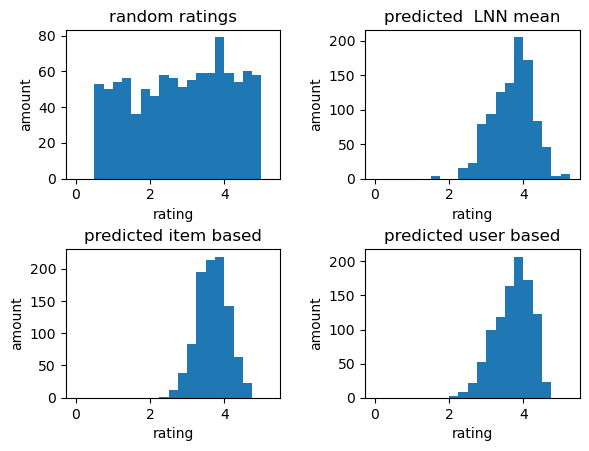

In [16]:
#Multiple visualisations used in results. 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
fig.tight_layout(pad=3.0)

axes = [ax1, ax2, ax3, ax4]
data = [predicted_random['predicted rating'], 
        predicted_item_mean['predicted rating'], 
        predicted_item_based['predicted rating'],
        predicted_user_based['predicted rating'],
        ]
titles = ["random ratings", "predicted  LNN mean", "predicted item based", "predicted user based", "predicted random"]

for ax, d, title in zip(axes, data, titles):
    ax.hist(list(d), bins=list(np.arange(0,5.5,0.25)))
    ax.set_xlabel("rating")
    ax.set_ylabel("amount")
    ax.set_title(title)
 

print('     | random | mean | item | user')
print('-----+--------+------+------+-----')
print(f'mean |   {data[0].mean():.2f} | {data[1].mean():.2f} | {data[2].mean():.2f} | {data[3].mean():.2f}')
print(f'std  |   {data[0].std():.2f} | {data[1].std():.2f} | {data[2].std():.2f} | {data[3].std():.2f}')

# Functions for precision and recall calculation

In [17]:
#A function that shows the amount of ratings that would be recommended using a treshold value.
def recommended(predictions, treshold):
    return predictions.where(predictions['predicted rating'] >= treshold).dropna()
    
#A function that shows the amount of ratings that would be hidden using a treshold value.
def hidden(predictions, treshold):
    return predictions.where(predictions['predicted rating'] < treshold).dropna()

#A function that retrieves all movies that users gave a high rating.
def used(actual, treshold):
    return actual.where(actual['rating'] >= treshold).dropna() 

#A function that retrieves all movies that users gave a low rating.
def unused(actual, treshold):
    return actual.where(actual['rating'] < treshold).dropna()

treshold_recommended = 3.75
treshold_used = 4
recommended_items = recommended(predicted_item_based, treshold_recommended)
hidden_items = hidden(predicted_item_based, treshold_recommended)
used_items = used(actual, treshold_used)
unused_items = unused(actual, treshold_used)

print(f'Test items : {predicted_item_based.shape[0]}')
print(f'Recommended: {recommended_items.shape[0]}')
print(f'Hidden     : {hidden_items.shape[0]}')
print(f'Used      : {used_items.shape[0]}')
print(f'Unused    : {unused_items.shape[0]}')
display(recommended_items.head())
display(hidden_items.head())
display(used_items.head())
display(unused_items.head())

Test items : 993
Recommended: 448
Hidden     : 545
Used      : 503
Unused    : 490


,userId,movieId,predicted rating
195,105.0,50.0,4.195964
207,105.0,750.0,4.217002
210,105.0,912.0,4.248759
217,105.0,1206.0,4.242905
218,105.0,1208.0,4.289307


,userId,movieId,predicted rating
1,68.0,2.0,3.487983
3,68.0,47.0,3.457851
6,68.0,110.0,3.625071
14,68.0,344.0,3.457997
27,68.0,593.0,3.494299


,userId,movieId,rating,difference
3,68.0,47.0,4.0,-0.083333
28,68.0,595.0,4.5,0.785714
33,68.0,912.0,4.5,0.2
46,68.0,1197.0,5.0,0.0
63,68.0,1291.0,5.0,0.5


,userId,movieId,rating,difference
1,68.0,2.0,2.5,0.0
6,68.0,110.0,2.5,-1.9
14,68.0,344.0,2.5,-0.5
27,68.0,593.0,3.5,-0.6875
39,68.0,1073.0,0.5,-2.375


# Confusion Matrix

In [18]:
#A function that visualises a confusion matrix and takes as input
#4 functions
def confusion(recommended, hidden, used, unused):
    int1 = 0
    int2 = 0
    int3 = 0
    int4 = 0
    
    for i in recommended.index:
        for q in used.index:
            if i == q:
                int1 = int1+ 1
        
    for j in hidden.index:
        for u in used.index:
            if j == u:
                int2 = int2+ 1
                
    int3 = len(recommended) - int1
    int4 = len(hidden) - int2
    
    confusion = pd.DataFrame(data ={'used':[int1,int2],'unused':[int3, int4]}, columns = ['used','unused'], index = ['recommended','hidden'])
    return confusion
    

confusion_matrix = confusion(recommended_items, hidden_items, used_items, unused_items)
display(confusion_matrix)

,used,unused
recommended,314,134
hidden,189,356


# Precision and Recall

In [19]:
#A function that evaluates the precision of a algorithm. It checks if a predicted movie
#is predicted correctly.
def precision(confusion_matrix):
    true = confusion_matrix.loc['recommended','used']
    false = confusion_matrix.loc['recommended','unused']
    answer = true/(true + false)
    return answer

precision_item_based = precision(confusion_matrix)

print(f'precision for item based prediction: {precision_item_based:.2f}')

#A function that evaluates if a movie should have been hidden instead of recommended
#based on the rating of a user.
def recall(confusion_matrix):
    true = confusion_matrix.loc['recommended','used']
    false = confusion_matrix.loc['hidden','unused']
    answer = true/(true + false)
    return answer

recall_item_based = recall(confusion_matrix)

print(f'recall for item based prediction: {recall_item_based:.2f}')

precision for item based prediction: 0.70
recall for item based prediction: 0.47


In [20]:
#A function that uses the recall and precision function to 
#calculate for all 4 algorithms and put it in a confusion matrix.
treshold_recommended = 3.75
treshold_used = 4.0

def precision_recall_matrix(predictions, true, treshold_r, treshold_u):
    r = recommended(predictions, treshold_r)
    h = hidden(predictions, treshold_r)
    u = used(true, treshold_u)
    x = unused(true, treshold_u)
    
    cm = confusion(r, h, u, x)
    return (precision(cm), recall(cm))

precision_user_based, recall_user_based = precision_recall_matrix(predicted_user_based, actual, treshold_recommended, treshold_used)
precision_random, recall_random = precision_recall_matrix(predicted_random, actual, treshold_recommended, treshold_used)
precision_item_mean, recall_item_mean = precision_recall_matrix(predicted_item_mean, actual, treshold_recommended, treshold_used)


print('           | precision | recall')
print(f'item based |      {precision_item_based:.2f} |   {recall_item_based:.2f}')
print(f'user based |      {precision_user_based:.2f} |   {recall_user_based:.2f}')
print(f'random     |      {precision_random:.2f} |   {recall_random:.2f}')
print(f'mean       |      {precision_item_mean:.2f} |   {recall_item_mean:.2f}')

           | precision | recall
item based |      0.70 |   0.47
user based |      0.66 |   0.53
random     |      0.55 |   0.33
mean       |      0.74 |   0.52


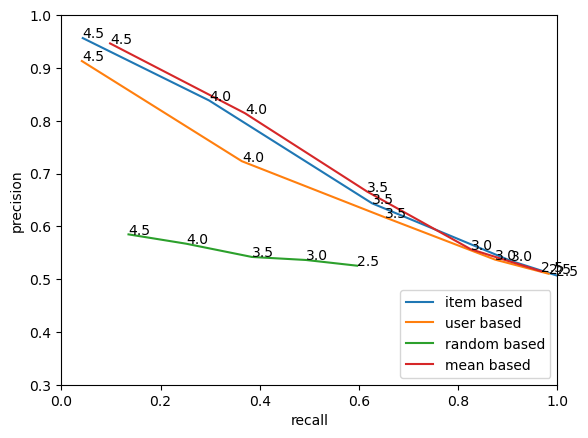

In [21]:
def plot(predictions, actual):
    for predicted, true in zip(predictions, actual):
        a = [precision_recall_matrix(predicted, true, i, 3.75) for i in [2.5, 3.0, 3.5, 4.0, 4.5]]
        precision = [i[0] for i in a]
        recall = [i[1] for i in a]
        
        plt.plot(recall, precision)
        for r, p, t in zip(recall, precision, [2.5, 3.0, 3.5, 4.0, 4.5]):
            plt.text(r, p, t)
            
    plt.xlim(0.0, 1.0)
    plt.ylim(0.3, 1.0)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend(['item based', 'user based', 'random based', 'mean based'], loc = 'lower right')
                
plot([predicted_item_based, predicted_user_based, predicted_random, predicted_item_mean], [actual for i in range (4)])